## SHAP Analysis

In [2]:
# Load necessary libraries
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed
np.random.seed(123)

# Load in dataset
data = pd.read_csv("../data/processed/diabetes_data_encoded.csv")

print(data.head())

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   age  gender  polyuria  polydipsia  sudden_weight_loss  weakness  \
0   40       1         0           1                   0         1   
1   58       1         0           0                   0         1   
2   41       1         1           0                   0         1   
3   45       1         0           0                   1         1   
4   60       1         1           1                   1         1   

   polyphagia  genital_thrush  visual_blurring  itching  irritability  \
0           0               0                0        1             0   
1           0               0                1        0             0   
2           1               0                0        1             0   
3           1               1                0        1             0   
4           1               0                1        1             1   

   delayed_healing  partial_paresis  muscle_stiffness  alopecia  obesity  \
0                1                0                 1         1 

In [3]:
# Define predictors and target
predictors = [
    'age', 'gender',
    'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness',
    'polyphagia', 'genital_thrush', 'visual_blurring', 'itching',
    'irritability', 'delayed_healing', 'partial_paresis',
    'muscle_stiffness', 'alopecia', 'obesity'
]
X = data[predictors]
y = data['diabetes']

In [4]:
# Split and standardize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Initiate logistic regression model
model = LogisticRegression(max_iter=1000)

# Fit model to data
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [6]:
# Compute SHAP values
explainer = shap.LinearExplainer(model, X_train_scaled, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_scaled)

# Convert back to dataframe for clarity
shap_df = pd.DataFrame(shap_values, columns=predictors)

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


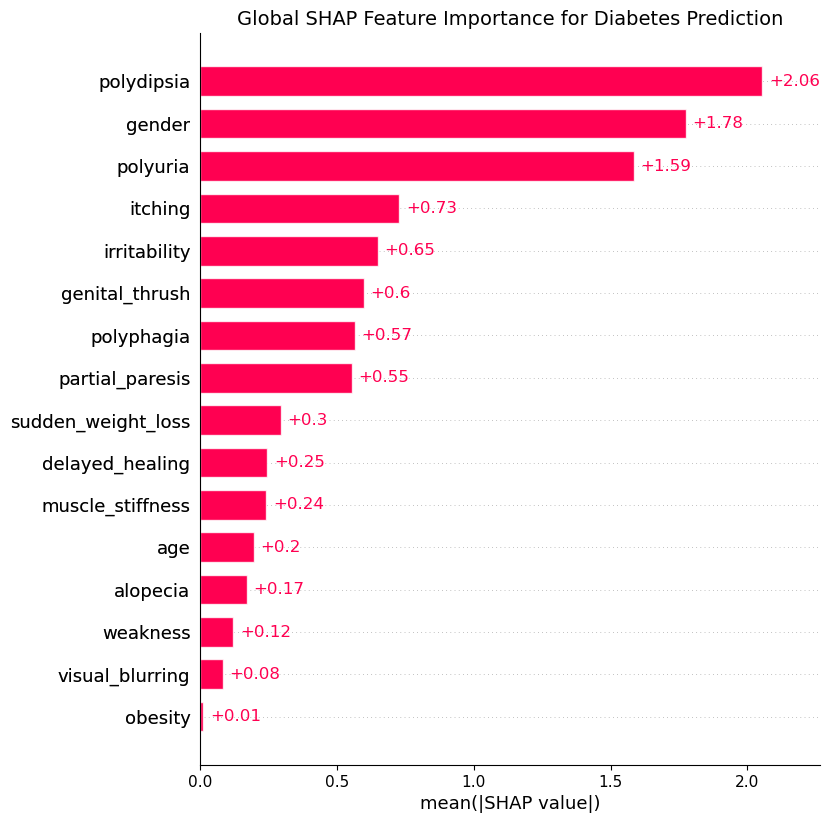

In [7]:
# Global SHAP feature importance bar plot showing ALL features
shap_values_expl = shap.Explanation(
    values = shap_values,
    base_values = explainer.expected_value,
    data = X_test,
    feature_names = predictors
)

plt.title("Global SHAP Feature Importance for Diabetes Prediction", fontsize=14)
shap.plots.bar(shap_values_expl, max_display=len(predictors))

This SHAP feature importance plot shows which features have the greatest overall impact on the model’s predictions for diabetes. Each bar represents the mean absolute SHAP value for a feature, meaning the average amount that feature influences the model’s output, regardless of direction. Features at the top of the chart are the most influential, while those near the bottom contribute relatively little.

The plot shows that polydipsia is by far the strongest predictor in the model, followed by gender and polyuria. These top features have much larger SHAP values than the rest, indicating that they consistently have a large effect on whether the model predicts diabetes. 

Symptoms such as itching, irritability, genital thrush, polyphagia, and partial paresis also play notable roles, although their contributions are smaller compared to the leading features. 

Sudden weight loss, delayed healing, and muscle stiffness have moderate importance, while demographic features like age and obesity have comparatively low influence. 

Visual blurring and weakness fall near the bottom, suggesting they have minimal overall impact on the model’s decision-making.

Overall, the plot indicates that the model relies most heavily on a few strong symptom indicators, with other symptoms contributing moderately and demographic factors contributing relatively little.

/var/folders/8f/psty_mqd6351cttsqy7dqj1w0000gn/T/ipykernel_70530/4246331564.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


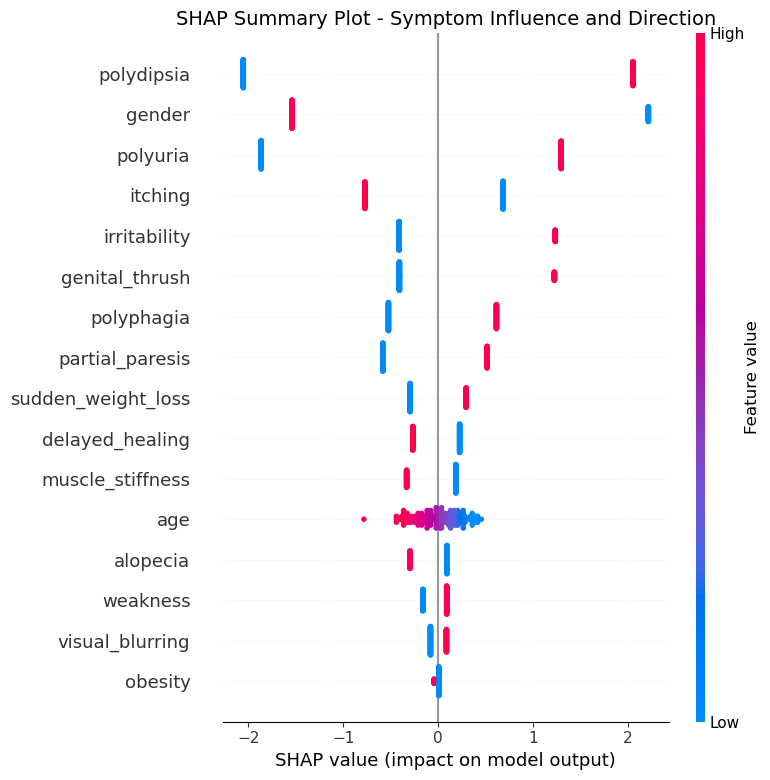

In [8]:
# Detailed SHAP Summary (Beeswarm) Plot

shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot - Symptom Influence and Direction", fontsize=14)
plt.tight_layout()
plt.show()

The SHAP summary plot shows how each feature (both symptoms and demographic factors) influences the model’s prediction of diabetes, including the direction (increase or decrease in predicted risk) and the strength of that influence. Each point represents one individual: red points indicate high feature values, blue points indicate low values, and the horizontal position shows whether that feature pushes the prediction toward (right) or away from (left) diabetes.

The plot shows that polydipsia, gender, and polyuria are the most influential features. High values for these features (red cluster on the right) significantly increase the model’s prediction of diabetes, while low values (blue cluster on the left) reduce it. The strong separation of colors; especially for polydipsia and polyuria, indicates that the presence of these symptoms is a powerful indicator of diabetes in the model.

Symptoms like itching, irritability, genital thrush, polyphagia, and partial paresis also show a consistent pattern where higher values tend to raise predicted risk but with moderate impact compared to the top features. Sudden weight loss, delayed healing, and muscle stiffness exhibit smaller but still noticeable effects.

Demographic features such as age and gender behave differently. Gender shows a clear direction: one gender category (represented by red) tends to push predictions upward, while the other (blue) pushes downward, suggesting a measurable difference in risk according to the model. Age, however, shows a dense cluster of points around 0, indicating a relatively weak and mixed influence.

Features near the bottom; such as alopecia, weakness, visual blurring, and obesity, have minimal impact with points tightly concentrated around 0, meaning they hardly influence the model’s prediction.

Overall, the model relies most heavily on strong symptom indicators and the gender variable, while other symptoms and demographic factors contribute to a lesser extent. This plot provides a detailed view not only of which features matter most but also how high or low values of those features affect the predicted probability of diabetes.

## Coefficient / Odds Ratio Forest Plot

In [9]:
# Coefficient / Odds Ratio Forest Plot

import statsmodels.api as sm

In [10]:
# 1. Define X and y using the same predictors and target as in the SHAP analysis
predictors1 = [
    'gender',
    'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness',
    'polyphagia', 'genital_thrush', 'visual_blurring', 'itching',
    'irritability', 'delayed_healing', 'partial_paresis',
    'muscle_stiffness', 'alopecia', 'obesity']

X_sm = data[predictors1]         # adjusted list to match logistic regression analysis
y_sm = data["diabetes"]          # encoded 0/1

In [11]:
# 2. Add intercept and fit logistic regression with statsmodels
X_sm_const = sm.add_constant(X_sm)

In [12]:
logit_model = sm.Logit(y_sm, X_sm_const).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.169179
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                  520
Model:                          Logit   Df Residuals:                      504
Method:                           MLE   Df Model:                           15
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.7461
Time:                        18:58:49   Log-Likelihood:                -87.973
converged:                       True   LL-Null:                       -346.46
Covariance Type:            nonrobust   LLR p-value:                1.440e-100
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8724      0.476      1.834      0.067      -0.060       1.804
gend

In [13]:
# 3. Build coefficient + confidence interval table
coef = logit_model.params
conf = logit_model.conf_int()
conf.columns = ["lower", "upper"]

coef_df = pd.concat([coef, conf], axis=1)
coef_df.columns = ["coef", "lower", "upper"]

# Drop intercept for plotting
coef_df = coef_df.drop("const")

In [14]:
# 4. Convert to odds ratios (easier to interpret clinically)
coef_df["odds_ratio"] = np.exp(coef_df["coef"])
coef_df["or_lower"]   = np.exp(coef_df["lower"])
coef_df["or_upper"]   = np.exp(coef_df["upper"])

# Sort predictors by odds ratio (or use abs(coef_df["coef"]) if you prefer)
coef_df = coef_df.reindex(coef_df["odds_ratio"].sort_values().index)

In [15]:
# 5. Plot odds ratio forest plot
plt.figure(figsize=(6, 4))

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

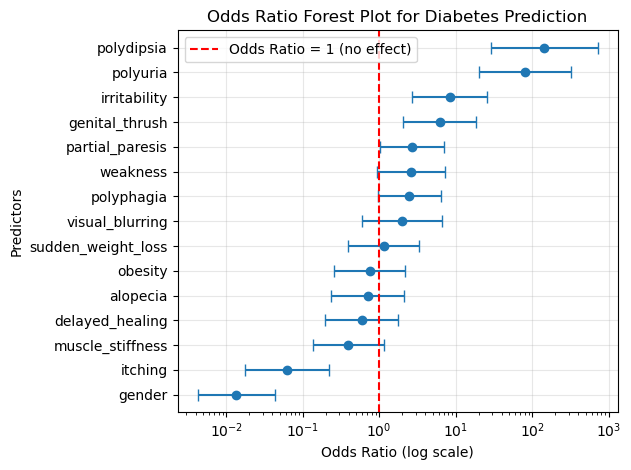

In [16]:
# xerr = distances from point estimate to lower/upper CI
xerr = [
    coef_df["odds_ratio"] - coef_df["or_lower"],
    coef_df["or_upper"] - coef_df["odds_ratio"],
]

plt.errorbar(
    coef_df["odds_ratio"],
    coef_df.index,
    xerr=xerr,
    fmt="o",
    capsize=4,
)

plt.axvline(1, color="red", linestyle="--", label="Odds Ratio = 1 (no effect)")
plt.xscale("log")  # log scale makes ORs easier to read
plt.xlabel("Odds Ratio (log scale)")
plt.ylabel("Predictors")
plt.title("Odds Ratio Forest Plot for Diabetes Prediction")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

The odds ratio forest plot summarizes how each predictor is statistically associated with early-stage diabetes after adjusting for all other symptoms. Predictors with odds ratios above 1 increase the likelihood of diabetes, and those with confidence intervals fully above 1 are the most reliable indicators.

The clearest predictors in the model are polydipsia and polyuria, both showing very large odds ratios with tight confidence intervals, confirming that excessive thirst and frequent urination are strong and statistically significant markers of diabetes. A second group of symptoms, including irritability, genital thrush, polyphagia, visual blurring, and partial paresis, also raise diabetes risk, though with more moderate effect sizes.

Variables such as alopecia, weakness, and obesity have odds ratios close to 1, indicating they do not meaningfully influence diabetes likelihood once other symptoms are considered. A few predictors fall below 1, but these likely reflect dataset characteristics rather than true protective effects.

The forest plot highlights which symptoms remain significant independent predictors in the adjusted model, complementing the SHAP results by focusing on statistical association rather than contribution to prediction.